In [1]:
import arviz as az
import numpy as np

# ArviZ ships with style sheets!
az.style.use("arviz-darkgrid")

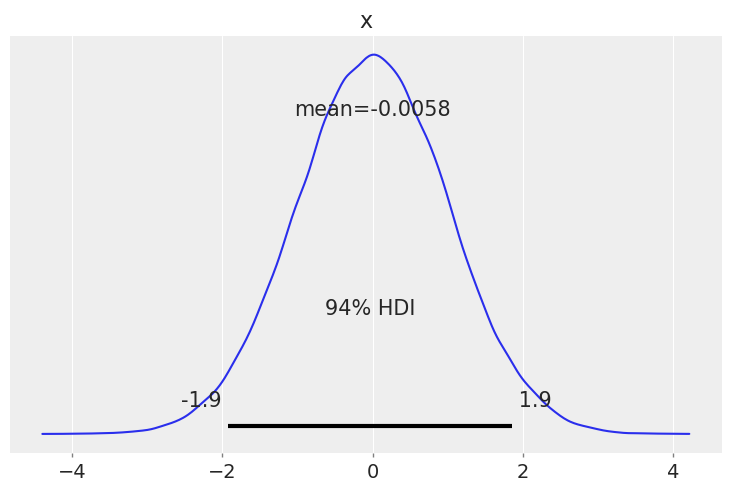

In [2]:
az.plot_posterior(np.random.randn(100_000));

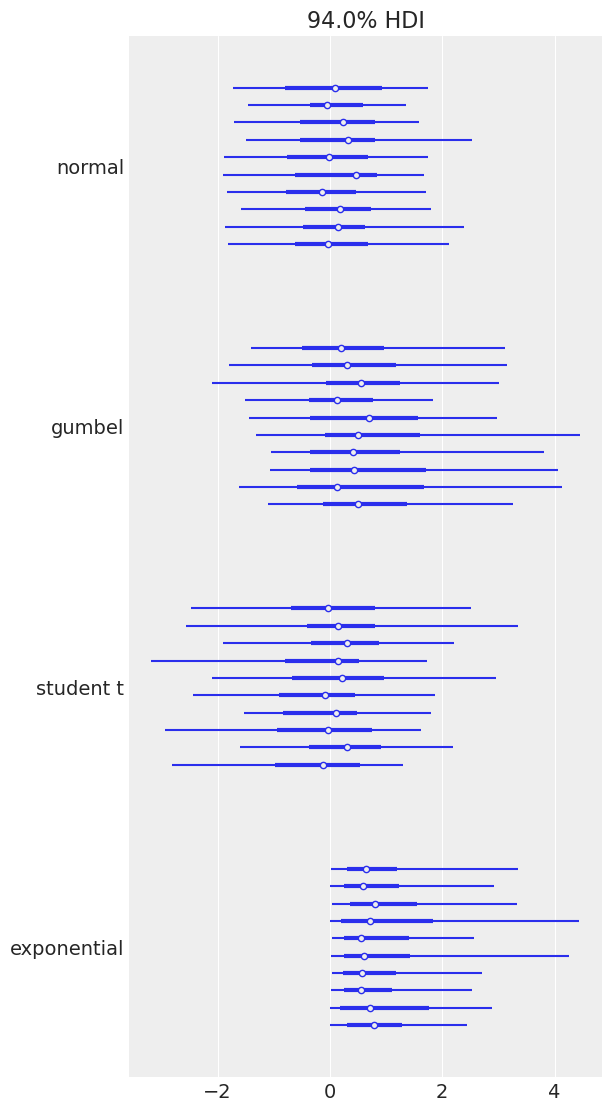

In [3]:
size = (10, 50)
az.plot_forest(
    {
        "normal": np.random.randn(*size),
        "gumbel": np.random.gumbel(size=size),
        "student t": np.random.standard_t(df=6, size=size),
        "exponential": np.random.exponential(size=size),
    }
);

## ArviZ rcParams


In [4]:
az.rcParams['stats.hdi_prob'] = 0.90

In [5]:
import pymc3 as pm

J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
schools = np.array(
    [
        "Choate",
        "Deerfield",
        "Phillips Andover",
        "Phillips Exeter",
        "Hotchkiss",
        "Lawrenceville",
        "St. Paul's",
        "Mt. Hermon",
    ]
)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [7]:
with pm.Model() as centered_eight:
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sd=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sd=sigma, observed=y)

    # This pattern is useful in PyMC3
    prior = pm.sample_prior_predictive()
    centered_eight_trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6660408409392651, but should be close to 0.8. Try to increase the number of tuning steps.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6653104882289026, but should be close to 0.8. Try to increase the number of tuning steps.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33125809220611147, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampl

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


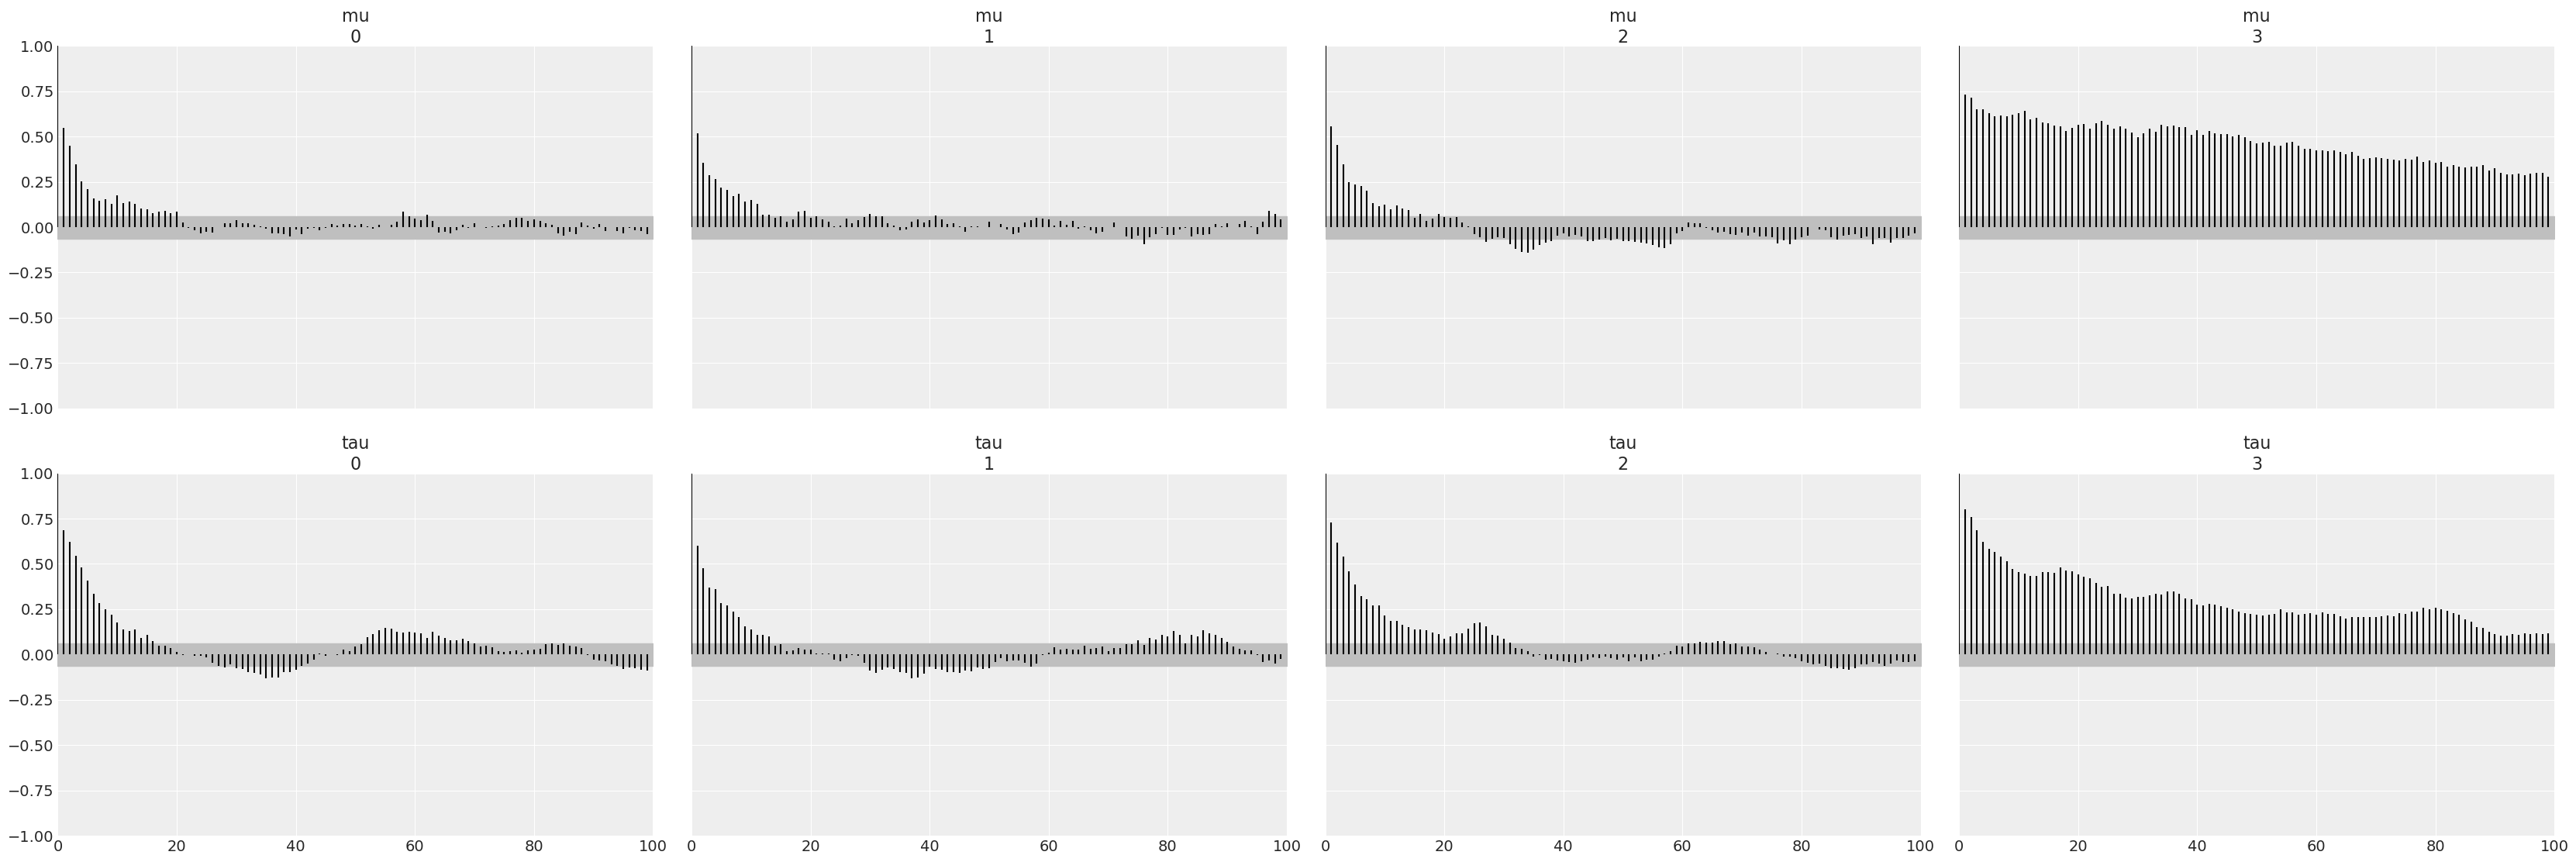

In [8]:
az.plot_autocorr(centered_eight_trace, var_names=["mu", "tau"]);

In [11]:
data = az.from_pymc3(
    trace=centered_eight_trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=centered_eight,
    coords={"school": schools},
    dims={"theta": ["school"], "obs": ["school"]},
)
data

0, dim: school, 8 =? 8


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [78]:
az.loo(data)

Computed from 4000 by 8 log-likelihood matrix

         Estimate       SE
elpd_loo   -31.06     1.52
p_loo        1.01        -

In [12]:
data.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    mu       (chain, draw) float64 5.131 5.041 3.288 4.981 ... 8.325 9.457 10.71
    theta    (chain, draw, school) float64 14.59 11.12 2.427 ... 13.48 10.64
    tau      (chain, draw) float64 4.595 6.493 7.991 7.885 ... 1.416 2.25 2.044
Attributes:
    created_at:                 2021-06-07T04:36:37.399166
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              2.4562034606933594
    tuning_steps:               1000

#### tmp = data.posterior.to_dataframe().unstack()
tmp

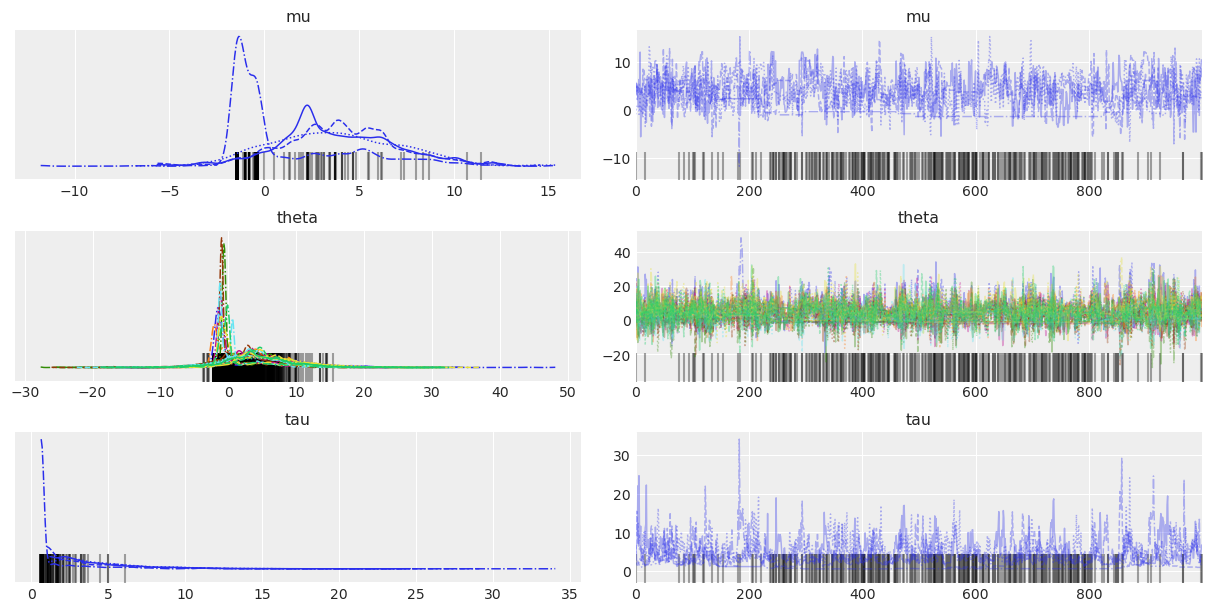

In [13]:
az.plot_trace(data);

In [15]:
cached = [(var, var.logp_elemwise) for var in centered_eight.observed_RVs]

In [37]:
type(cached[0][0])  # observed random variable

pymc3.model.ObservedRV

In [28]:
cached[0][0]

obs ~ Normal

In [39]:
cached[0][0].name

'obs'

In [42]:
cached[0][0].logp_elemwise

# LoosePoitFunc has two properties: `f`, `model`

In [47]:
cached[0][0].logp_elemwise.f

# .f is an theano.complie.function.types.Function
# https://github.com/Theano/Theano/blob/master/theano/compile/function_module.py#L225

In [54]:
cached[0][0].logp_elemwise.f.maker

# https://github.com/Theano/Theano/blob/master/theano/compile/function_module.py#L1185

In [61]:
cached[0][0].logp_elemwise.f.maker.inputs

[In(mu ~ Normal), In(tau_log__ ~ TransformedDistribution), In(theta ~ Normal)]

In [64]:
cached[0][0].logp_elemwise.f.maker.outputs # a list

[Out(Elemwise{switch,no_inplace}.0,False)]

In [65]:
cached[0][0].logp_elemwise.f.maker.name

'/opt/conda/lib/python3.7/site-packages/pymc3/model.py:1262'

In [66]:
cached[0][0].logp_elemwise.f.maker.expanded_inputs

[In(mu ~ Normal), In(tau_log__ ~ TransformedDistribution), In(theta ~ Normal)]

In [67]:
cached[0][0].logp_elemwise.f.maker.output_keys 

In [68]:
cached[0][0].logp_elemwise.f.maker.indices

[[In(mu ~ Normal), None, [In(mu ~ Normal)]],
 [In(tau_log__ ~ TransformedDistribution),
  None,
  [In(tau_log__ ~ TransformedDistribution)]],
 [In(theta ~ Normal), None, [In(theta ~ Normal)]]]

In [56]:
cached[0][0].logp_elemwise.f.input_storage

[<None>, <None>, <None>]

In [57]:
cached[0][0].logp_elemwise.f.output_storage

[<None>]

In [58]:
cached[0][0].logp_elemwise.f.indices

[[In(mu ~ Normal), None, [In(mu ~ Normal)]],
 [In(tau_log__ ~ TransformedDistribution),
  None,
  [In(tau_log__ ~ TransformedDistribution)]],
 [In(theta ~ Normal), None, [In(theta ~ Normal)]]]

In [59]:
cached[0][0].logp_elemwise.f.fn

In [48]:
cached[0][0].logp_elemwise.model

In [ ]:
# https://github.com/pymc-devs/pymc3/model.py#L280
class Factor:
    @property
    def logp_elemwise(self):
        return self.model.fn(self.logp_elemwiset)
    
# https://github.com/pymc-devs/pymc3/model.py#L1418
    def fn(self, outs, mode=None, *args, **kwargs):
        """Compiles an Aesara function which returns the values of ``outs``
        and takes values of model vars as arguments.
        Parameters
        ----------
        outs: Aesara variable or iterable of Aesara variables
        mode: Aesara compilation mode
        Returns
        -------
        Compiled Aesara function
        """
        return LoosePointFunc(self.makefn(outs, mode, *args, **kwargs), self)

# https://github.com/pymc-devs/pymc3/model.py#L1393
    def makefn(self, outs, mode=None, *args, **kwargs):
        """Compiles an Aesara function which returns ``outs`` and takes the variable
        ancestors of ``outs`` as inputs.
        Parameters
        ----------
        outs: Aesara variable or iterable of Aesara variables
        mode: Aesara compilation mode, default=None
        Returns
        -------
        Compiled Aesara function
        """
        with self:
            return compile_rv_inplace(
                self.value_vars,
                outs,
                allow_input_downcast=True,
                on_unused_input="ignore",
                accept_inplace=True,
                mode=mode,
                *args,
                **kwargs,
            )
        
# https://github.com/pymc-devs/pymc3/model.py#L1784
class LoosePointFunc:
    """Wraps so a function so it takes a dict of arguments instead of arguments
    but can still take arguments."""

    def __init__(self, f, model):
        self.f = f
        self.model = model

    def __call__(self, *args, **kwargs):
        point = Point(model=self.model, *args, filter_model_vars=True, **kwargs)
        return self.f(**point)

In [44]:
cached[0][1].f

In [77]:
cached[0][1].f.input_storage

[<None>, <None>, <None>]

In [35]:
cached[0][1].model

In [41]:
for var in centered_eight.observed_RVs:
    print(var)

obs ~ Normal


In [69]:
cached[0]

(obs ~ Normal, <pymc3.model.LoosePointFunc at 0x7ffa54985c10>)

In [71]:
cached[0][0]

obs ~ Normal

In [72]:
cached[0][1]

How the point-wise loglikelihood is calculated in `io_PyMC3.py`?

It was calculated by `log_likelihood_vals_point()` function, which takes `point`, `var`, and `log_like_fun`, and gives `log_like_val` by `log_like_fun(point)`

the `log_likehood_vals_point()` is used in `_extract_log_likelihood`, where `log_like_chain = [self.log_likelihood_vals_point(point, var, log_like_fun) for point in trace.points([chain])`. Importantly, in `_extract_log_likelihood`, `var` and `log_like_fun` is from `cached`, which is from `cached = [(var, var.logp_elemwise) for var in self.model.observed_RVs]`; and `chain` is from `enumerate(trace.chains)`.

Therefore, the `log_like_fun()` in `log_like_fun(point)` is from `cached`, which is from `self.model.observed_RVs`.

If we print `[(var, var.logp_elemwise) for var in self.model.observed_RVs]`, we will get only one output `obs ~ Normal`, which mean the observed stocahtistic variable in pymc3. So `cached` only has one element in this case, which is a `pymc3.model.LoosePointFunc` object.  This object `cached[0]` has two elements `cached[0][0]` is `pymc3.model.ObservedRV`, `cached[0][1]` is a `LoosePointFunc`. `cached[0][0]` has a property `.logp_elemwise`, which is, again, a `LoosePointFunc`. Use `LoosePointFunc`'s properties `f`, we can check its `input`, `output` etc, but the exact function of it is still unknown.

In [ ]:
# class PyMC3Converter:
# https://github.com/arviz-devs/arviz/blob/main/arviz/data/io_pymc3.py#L216
def log_likelihood_vals_point(self, point, var, log_like_fun):
    """Compute log likelihood for each observed point.
    Here, point, var, and log_like_fun are input!
    """
    # so there the log_like_fun(point) is the core function
    # log_like_fun is from cached, which is the var.logp_elewise
    # the var.logp_elewise is from .model.observed_RVs
    # the point is from trace.points([chain]), not `var`.
    
    log_like_val = utils.one_de(log_like_fun(point))
    
    if var.missing_values:
        mask = var.observations.mask
        if np.ndim(mask) > np.ndim(log_like_val):
            mask = np.any(mask, axis=-1)
        log_like_val = np.where(mask, np.nan, log_like_val)
    return log_like_val
    
# https://github.com/arviz-devs/arviz/blob/main/arviz/utils.py#L365 
def one_de(x):
    """Jitting numpy atleast_1d."""
    if not isinstance(x, np.ndarray):
        return np.atleast_1d(x) # convert inputs to arrays w/ at least onen dimension.
    if x.ndim == 0:
        result = x.reshape(1)
    else:
        result = x
    return result

**logp_elemwise** is the **log_like_fun** which is the key to pointwise log likelihood.

 `cached = [(var, var.logp_elemwise) for var in self.model.observed_RVs]` means that `logp_elewise` is in `self.model.observed_RVs`
 
 `self.model`'s `observed_RVs` is the key!

In [ ]:
# class PyMC3Converter:
# https://github.com/arviz-devs/arviz/blob/main/arviz/data/io_pymc3.py#L226
def _extract_log_likelihood(self, trace):
    """Compute log likelihood of each observation.
    only input is trace!
    """
    if self.trace is None:
        return None
    if self.model is None:
        return None

    # If we have predictions, then we have a thinned trace which does not
    # support extracting a log likelihood.
    if self.log_likelihood is True:
        # var is looped in observed data
        # here the logp_elemwise is the log_like_fun ***
        # so where does the self.model.observed_RVs come from is very important!
        # model come from pymc3.modelcontext 
        #(https://github.com/pymc-devs/pymc3/blob/main/pymc3/model.py#L251)
        # which in turn relies on Model.get_contexts()
        cached = [(var, var.logp_elemwise) for var in self.model.observed_RVs]
    else:
        cached = [
            (var, var.logp_elemwise)
            for var in self.model.observed_RVs
            if var.name in self.log_likelihood
        ]
    try:
        # using pymc3 sampling default trace.
        log_likelihood_dict = (
            self.pymc3.sampling._DefaultTrace(  # pylint: disable=protected-access
                len(trace.chains)
            )
        )
    except AttributeError as err:
        raise AttributeError(
            "Installed version of ArviZ requires PyMC3>=3.8. Please upgrade with "
            "`pip install pymc3>=3.8` or `conda install -c conda-forge pymc3>=3.8`."
        ) from err
        
    # var and log_like_fun are from cached, that is, from observed_RVs
    for var, log_like_fun in cached:
        try:
            for k, chain in enumerate(trace.chains):
                
                # here loop at each data point?
                log_like_chain = [
                    self.log_likelihood_vals_point(point, var, log_like_fun)
                    for point in trace.points([chain])
                ]
                
                # what does it mean?
                log_likelihood_dict.insert(var.name, np.stack(log_like_chain), k)
        except TypeError as e:
            raise TypeError(
                *tuple(["While computing log-likelihood for {var}: "] + list(e.args))
            ) from e
    # return log_likelihood_dict
    return log_likelihood_dict.trace_dict

`self.model` is come from `self.pymc3.modecontext(model or self.model)`, which means get a model.



In [ ]:
# https://github.com/arviz-devs/arviz/blob/main/arviz/data/io_pymc3.py#L89
        # this permits us to get the model from command-line argument or from with model:
        try:
            self.model = self.pymc3.modelcontext(model or self.model)
        except TypeError as e:
            _log.error("Got error %s trying to find log_likelihood in translation.", e)
            self.model = None

        if self.model is None:
            warnings.warn(
                "Using `from_pymc3` without the model will be deprecated in a future release. "
                "Not using the model will return less accurate and less useful results. "
                "Make sure you use the model argument or call from_pymc3 within a model context.",
                FutureWarning,
            )

In [ ]:
# https://github.com/pymc-devs/pymc3/model.py#L251
def modelcontext(model: Optional["Model"]) -> "Model":
    """
    Return the given model or, if none was supplied, try to find one in
    the context stack.
    """
    if model is None:
        model = Model.get_context(error_if_none=False)

        if model is None:
            # TODO: This should be a ValueError, but that breaks
            # ArviZ (and others?), so might need a deprecation.
            raise TypeError("No model on context stack.")
    return model

`model.observed_RVs`:


In [ ]:
self.observed_RVs = treelist(parent=self.parent.observed_RVs)

or 

self.observed_RVs = treelist()

In [ ]:
# https://github.com/arviz-devs/arviz/blob/main/arviz/data/io_pymc3.py#L332

def log_likelihood_to_xarray(self):
    """Extract log likelihood and log_p data from PyMC3 trace."""
    if self.predictions or not self.log_likelihood:
        return None
    data_warmup = {}
    data = {}
    warn_msg = (
        "Could not compute log_likelihood, it will be omitted. "
        "Check your model object or set log_likelihood=False"
    )
    
    # if there is ponsterior_trace, use posterior_trace to extract likelihood
    
    if self.posterior_trace:
        try:
            data = self._extract_log_likelihood(self.posterior_trace)
        except TypeError:
            warnings.warn(warn_msg)
    if self.warmup_trace:
        try:
            data_warmup = self._extract_log_likelihood(self.warmup_trace)
        except TypeError:
            warnings.warn(warn_msg)
    return (
        dict_to_dataset(
            data, library=self.pymc3, dims=self.dims, coords=self.coords, skip_event_dims=True
        ),
        dict_to_dataset(
            data_warmup,
            library=self.pymc3,
            dims=self.dims,
            coords=self.coords,
            skip_event_dims=True,
        ),
    )